In [1]:
import pandas as pd 
df_sales = pd.read_csv('florist-order-record.csv')
df_sales.head()

,Order,ProductID,Date,Products,Number,Price,UserID,City
0,536374,21258,6/1/2020 9:09,Five Colorful Roses,32,10.95,15100,Beijing
1,536376,22114,6/1/2020 9:32,25 White Jasmine,48,3.45,15291,Shanghai
2,536376,21733,6/1/2020 9:32,3 Sunflowers 5 Eucalyptus,64,2.55,15291,Shanghai
3,536378,22386,6/1/2020 9:37,Lily Pink,10,1.95,14688,Beijing
4,536378,85099C,6/1/2020 9:37,Champagne Carnation,10,1.95,14688,Beijing


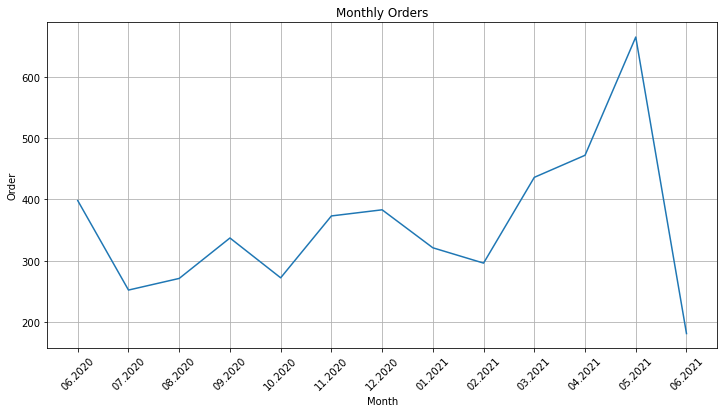

In [2]:
import matplotlib.pyplot as plt
df_sales['Date'] = pd.to_datetime(df_sales['Date'])
df_orders_monthly = df_sales.set_index('Date')['Order'].resample('M').nunique()
ax = pd.DataFrame(df_orders_monthly.values).plot(grid=True,figsize=(12,6),legend=False)
ax.set_xlabel('Month')
ax.set_ylabel('Order')
ax.set_title('Monthly Orders')
plt.xticks(
    range(len(df_orders_monthly.index)), 
    [x.strftime('%m.%Y') for x in df_orders_monthly.index], 
    rotation=45)
plt.show()

In [3]:
df_sales = df_sales.drop_duplicates()

In [4]:
df_sales.isna().sum()

Order        0
ProductID    0
Date         0
Products     0
Number       0
Price        0
UserID       0
City         0
dtype: int64

In [5]:
df_sales.describe()

,Number,Price,UserID
count,85920.000000,85920.000000,85920.000000
mean,10.115747,3.599711,15338.080389
std,49.114285,134.410498,391.309086
min,-9360.000000,0.000000,14681.000000
25%,2.000000,1.250000,15022.000000
50%,4.000000,1.950000,15334.000000
75%,12.000000,3.750000,15673.000000
max,3114.000000,38970.000000,16019.000000


In [6]:
df_sales = df_sales.loc[df_sales['Number'] > 0]

In [7]:
df_sales.describe()

,Number,Price,UserID
count,84112.000000,84112.000000,84112.000000
mean,10.760236,3.005032,15337.732963
std,34.018906,15.365085,392.074855
min,1.000000,0.000000,14681.000000
25%,2.000000,1.250000,15021.000000
50%,5.000000,1.950000,15333.000000
75%,12.000000,3.750000,15674.000000
max,3114.000000,3155.950000,16019.000000


In [8]:
df_sales['TotalPrice'] = df_sales['Number'] * df_sales['Price']
df_sales.head()

,Order,ProductID,Date,Products,Number,Price,UserID,City,TotalPrice
0,536374,21258,2020-06-01 09:09:00,Five Colorful Roses,32,10.95,15100,Beijing,350.4
1,536376,22114,2020-06-01 09:32:00,25 White Jasmine,48,3.45,15291,Shanghai,165.6
2,536376,21733,2020-06-01 09:32:00,3 Sunflowers 5 Eucalyptus,64,2.55,15291,Shanghai,163.2
3,536378,22386,2020-06-01 09:37:00,Lily Pink,10,1.95,14688,Beijing,19.5
4,536378,85099C,2020-06-01 09:37:00,Champagne Carnation,10,1.95,14688,Beijing,19.5


In [9]:
df_user = pd.DataFrame(df_sales['UserID'].unique())
df_user.columns = ['UserID']
df_user = df_user.sort_values(by='UserID',ascending=True).reset_index(drop=True)
df_user

,UserID
0,14681
1,14682
2,14684
3,14687
4,14688
...,...
975,16015
976,16016
977,16017
978,16018


In [10]:
df_sales['Date'] = pd.to_datetime(df_sales['Date'])
df_recent_buy = df_sales.groupby('UserID').Date.max().reset_index()
df_recent_buy.columns = ['UserID','LastDate']
df_recent_buy['Recency'] = (df_recent_buy['LastDate'].max() - df_recent_buy['LastDate']).dt.days
df_user = pd.merge(df_user, df_recent_buy[['UserID','Recency']], on='UserID')
df_user.head()

,UserID,Recency
0,14681,70
1,14682,187
2,14684,25
3,14687,106
4,14688,7


In [11]:
df_frequency = df_sales.groupby('UserID').Date.count().reset_index()
df_frequency.columns = ['UserID','Frequency']
df_user = pd.merge(df_user, df_frequency, on='UserID')
df_user.head()

,UserID,Recency,Frequency
0,14681,70,7
1,14682,187,2
2,14684,25,390
3,14687,106,15
4,14688,7,324


In [12]:
df_revenue = df_sales.groupby('UserID').TotalPrice.sum().reset_index()
df_revenue.columns = ['UserID','Monetary']
df_user = pd.merge(df_user, df_revenue, on='UserID')
df_user.head()

,UserID,Recency,Frequency,Monetary
0,14681,70,7,498.95
1,14682,187,2,52.00
2,14684,25,390,1201.51
3,14687,106,15,628.38
4,14688,7,324,5579.10


<AxesSubplot:title={'center':'New progress histogram'}, ylabel='Frequency'>

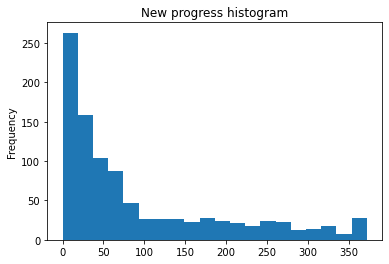

In [13]:
df_user['Recency'].plot(kind='hist', bins=20, title = 'New progress histogram')

<AxesSubplot:title={'center':'Consumption frequency histogram'}, ylabel='Frequency'>

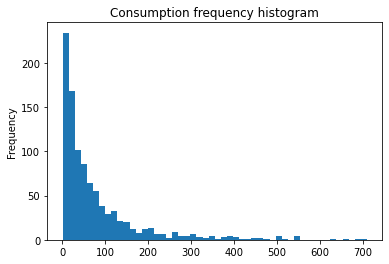

In [15]:
df_user.query('Frequency < 800')['Frequency'].plot(kind='hist', bins=50, title = 'Consumption frequency histogram')

<AxesSubplot:title={'center':'Consumption amount histogram'}, ylabel='Frequency'>

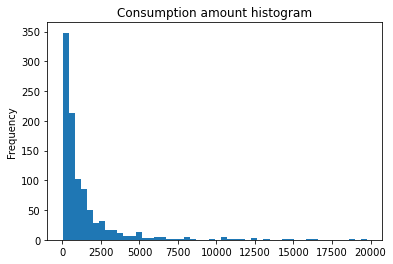

In [16]:
df_user.query('Monetary < 20000')['Monetary'].plot(kind='hist', bins=50, title = 'Consumption amount histogram')

In [17]:
from sklearn.cluster import KMeans
def show_elbow(df):
    distance_list = []
    K = range(1,9)
    for k in K:
        kmeans = KMeans(n_clusters=k, max_iter=100)
        kmeans = kmeans.fit(df)
        distance_list.append(kmeans.inertia_)
    plt.plot(K, distance_list, 'bx-')
    plt.xlabel('k')
    plt.ylabel('distance mean square error')
    plt.title('K elbow diagram')

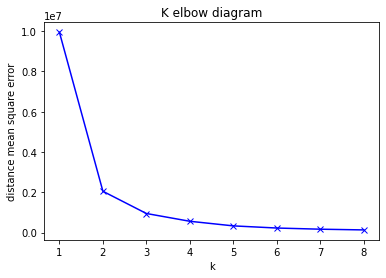

In [18]:
show_elbow(df_user[['Recency']])

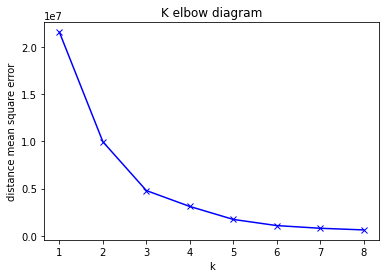

In [19]:
show_elbow(df_user[['Frequency']])

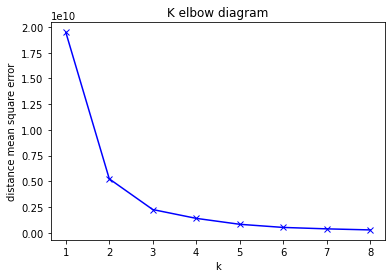

In [20]:
show_elbow(df_user[['Monetary']])

In [21]:
from sklearn.cluster import KMeans
kmeans_R = KMeans(n_clusters=3)
kmeans_F = KMeans(n_clusters=4)
kmeans_M = KMeans(n_clusters=4)

In [22]:
kmeans_R.fit(df_user[['Recency']])
kmeans_F.fit(df_user[['Frequency']])
kmeans_M.fit(df_user[['Monetary']])

KMeans(n_clusters=4)

In [23]:
df_user['RecencyLevel'] = kmeans_R.predict(df_user[['Recency']])
df_user.head()

,UserID,Recency,Frequency,Monetary,RecencyLevel
0,14681,70,7,498.95,0
1,14682,187,2,52.00,2
2,14684,25,390,1201.51,0
3,14687,106,15,628.38,2
4,14688,7,324,5579.10,0


In [24]:
df_user.groupby('RecencyLevel')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyLevel,,,,,,,,
0,664.0,32.088855,25.141763,0.0,10.00,25.0,50.00,94.0
1,138.0,298.094203,45.436550,231.0,255.25,292.5,334.50,372.0
2,178.0,157.162921,37.340870,95.0,126.00,156.5,188.75,225.0


In [25]:
def order_cluster(cluster_name, target_name,df,ascending=False):
    new_cluster_name = 'new_' + cluster_name
    df_new = df.groupby(cluster_name)[target_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_new = pd.merge(df,df_new[[cluster_name,'index']], on=cluster_name)
    df_new = df_new.drop([cluster_name],axis=1)
    df_new = df_new.rename(columns={"index":cluster_name})
    return df_new

In [26]:
df_user = order_cluster('RecencyLevel', 'Recency', df_user, False)
df_user = df_user.sort_values(by='UserID',ascending=True).reset_index(drop=True)
df_user.head()

,UserID,Recency,Frequency,Monetary,RecencyLevel
0,14681,70,7,498.95,2
1,14682,187,2,52.00,1
2,14684,25,390,1201.51,2
3,14687,106,15,628.38,1
4,14688,7,324,5579.10,2


In [27]:
df_user.groupby('RecencyLevel')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyLevel,,,,,,,,
0,138.0,298.094203,45.436550,231.0,255.25,292.5,334.50,372.0
1,178.0,157.162921,37.340870,95.0,126.00,156.5,188.75,225.0
2,664.0,32.088855,25.141763,0.0,10.00,25.0,50.00,94.0


In [28]:
df_user['FrequencyLevel'] = kmeans_F.predict(df_user[['Frequency']])
df_user = order_cluster('FrequencyLevel', 'Frequency',df_user,True)
df_user.groupby('FrequencyLevel')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyLevel,,,,,,,,
0,720.0,32.277778,24.128263,1.0,12.00,27.0,48.25,92.0
1,203.0,152.960591,50.338738,93.0,113.50,138.0,191.50,279.0
2,50.0,417.080000,109.618232,289.0,329.75,390.0,492.50,710.0
3,7.0,1281.000000,515.121345,887.0,996.50,1112.0,1304.50,2366.0


In [29]:
df_user = df_user.sort_values(by='UserID',ascending=True).reset_index(drop=True)
df_user.head()

,UserID,Recency,Frequency,Monetary,RecencyLevel,FrequencyLevel
0,14681,70,7,498.95,2,0
1,14682,187,2,52.00,1,0
2,14684,25,390,1201.51,2,2
3,14687,106,15,628.38,1,0
4,14688,7,324,5579.10,2,2


In [30]:
df_user['MonetaryLevel'] = kmeans_M.predict(df_user[['Monetary']])
df_user = order_cluster('MonetaryLevel', 'Monetary',df_user,True)
df_user.groupby('MonetaryLevel')['Monetary'].describe()
df_user = df_user.sort_values(by='UserID',ascending=True).reset_index(drop=True)
df_user.head()

,UserID,Recency,Frequency,Monetary,RecencyLevel,FrequencyLevel,MonetaryLevel
0,14681,70,7,498.95,2,0,0
1,14682,187,2,52.00,1,0,0
2,14684,25,390,1201.51,2,2,0
3,14687,106,15,628.38,1,0,0
4,14688,7,324,5579.10,2,2,1


In [31]:
df_user['Score'] = df_user['RecencyLevel'] + df_user['FrequencyLevel'] + df_user['MonetaryLevel']

In [32]:
df_user.loc[(df_user['Score']<=2) & (df_user['Score']>=0), 'Value'] = 'Low' 
df_user.loc[(df_user['Score']<=4) & (df_user['Score']>=3), 'Value'] = 'Medium' 
df_user.loc[(df_user['Score']<=8) & (df_user['Score']>=5), 'Value'] = 'High'
df_user

,UserID,Recency,Frequency,Monetary,RecencyLevel,FrequencyLevel,MonetaryLevel,Score,Value
0,14681,70,7,498.95,2,0,0,2,Low
1,14682,187,2,52.00,1,0,0,1,Low
2,14684,25,390,1201.51,2,2,0,4,Medium
3,14687,106,15,628.38,1,0,0,1,Low
4,14688,7,324,5579.10,2,2,1,5,High
...,...,...,...,...,...,...,...,...,...
975,16015,3,181,704.55,2,1,0,3,Medium
976,16016,2,224,1465.51,2,1,0,3,Medium
977,16017,46,32,211.88,2,0,0,2,Low
978,16018,38,28,408.90,2,0,0,2,Low
